In [1]:
import pandas as pd
import numpy as np

civious_df = pd.read_csv('./data/Dataset.csv.txt', delimiter='\t')

#### **데이터 전처리**

1. puntuation 제거 (숫자로 비속어를 표현하는 경우도 있기때문에 숫자는 남겨둠)

civious_df['lable'].isnull()label null 인 것 처리(content에 같이 들어가 있었음)

하는 김에 label도 int로 바꿔줌

In [2]:
civious_df['lable'].isnull().sum()

25

In [3]:
for i in civious_df[civious_df['lable'].isnull()].index :
    textNlabel = civious_df.loc[i, 'content'].split('\t')
    civious_df.loc[i, 'content'] = textNlabel[0]
    civious_df.loc[i, 'lable'] = int(textNlabel[1])

In [4]:
civious_df['content'] = civious_df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]","", regex=True)
# civious_df['content'] = civious_df['content'].str.replace("[:punct:]","", regex=True)

In [5]:
civious_df['lable'] = civious_df['lable'].apply(lambda x : int(x))

In [6]:
civious_df['lable'] = civious_df['lable'].replace([1,0],[0,1])

In [7]:
civious_df.head(5)

,content,lable
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다 2년전인가 좀 신선했었지 근데 이...,1
1,씨바알노무노무 술프노 오늘 저녁은 꽂등심이다ㅠㅜ,1
2,짱깨 꺼라ㅡ패쓰,1
3,그들의 사생활 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨소...,0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0


2. 중복 제거

In [8]:
civious_df.nunique()

content    9982
lable         2
dtype: int64

In [9]:
civious_df.drop_duplicates(subset=['content'], inplace=True, ignore_index=True)

In [10]:
civious_df.shape

(9982, 2)

3. puntuation 제거 후 빈 문자열이 된 데이터가 있는지 확인

In [11]:
civious_df['content'].replace('', np.nan, inplace=True)

In [12]:
civious_df.shape

(9982, 2)

In [13]:
print(civious_df['content'].isnull().sum())

0


content column에 빈 문자열은 없음!

#### **토큰화**

Okt

In [14]:
stopwords = []
stopwords_file = open('./data/korean_stopwords.txt', 'r', encoding='UTF8')
stopwords_lines = stopwords_file.readlines()
for line in stopwords_lines :
    stopwords.append(line.split('\t')[0])

In [15]:
import jpype #이거 안쓰면 에러남!!!!
from konlpy.tag import Okt

okt = Okt()

In [16]:
toknized_df = pd.DataFrame(columns=['text', 'label'])

In [17]:
for i in civious_df.index :
    sentence = civious_df.loc[i, 'content']
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    toknized_df.loc[i, 'text'] = temp_X

In [18]:
toknized_df['label'] = civious_df['lable']

In [19]:
toknized_df.head(5)

,text,label
0,"[이종석, 한효주, 나오다, 드라마, 이후, 로, 드라마, 보다, 2년, 전인가, ...",1
1,"[씨, 바알, 노무, 노무, 술프노, 오늘, 저녁, 은, 꽂다, 등심, 이다, ㅠㅜ]",1
2,"[짱깨, 끄다, ㅡ, 패쓰]",1
3,"[의, 사생활, 고인, 되다, 설리, 를, 위, 하다, 모두, 조용하다, 누굴, 탓...",0
4,"[아무리, 법, 뭣같아, 도, 무슨, 자격, 으로, 개인, 의, 신상, 정보, 를,...",0


#### **인코딩**

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(toknized_df['text'])

In [21]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 15680
등장 빈도가 2번 이하인 희귀 단어의 수: 10035
단어 집합에서 희귀 단어의 비율: 63.99872448979592
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.110836700545818


3회 미만으로 등장하는 단어가 9.11퍼센트를 차지한다.

In [22]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5646


In [23]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(toknized_df['text'])
toknized_df['encoding'] = tokenizer.texts_to_sequences(toknized_df['text'])

문장을 구성하는 모든 단어가 희귀 단어여서 빈 encoding sequence를 생성하는 경우를 제거

In [24]:
drop_index = [index for index, sentence in enumerate(toknized_df['encoding']) if len(sentence) < 1]

In [25]:
len(drop_index)

15

In [26]:
toknized_df.drop(index=drop_index, axis=0, inplace=True)
# toknized_df = np.delete(toknized_df, drop_index, axis=0)
toknized_df.reset_index(inplace=True, drop=True)

In [27]:
toknized_df.shape

(9967, 3)

In [28]:
toknized_df[['label']].value_counts()

label
0        4989
1        4978
dtype: int64

#### **패딩**
샘플 길이 맞춰주는 과정

시퀀스 최대 길이 : 243
시퀀스 평균 길이 : 12.480184609210394


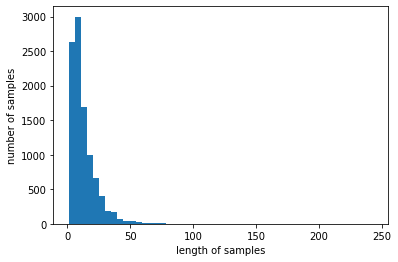

In [29]:
import matplotlib.pyplot as plt

print('시퀀스 최대 길이 :',max(len(l) for l in toknized_df['encoding']))
print('시퀀스 평균 길이 :',sum(map(len, toknized_df['encoding']))/len(toknized_df['encoding']))
plt.hist([len(s) for s in toknized_df['encoding']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

최적의 시퀀스 길이(대부분의 텍스트가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값)는?

In [30]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [31]:
max_len = 40
below_threshold_len(max_len, toknized_df['encoding'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 97.85291461824019


전체 데이터 중 약 97.8%의 샘플이 40 이하의 길이를 가짐. 모든 시퀀스 길이를 40으로 맞추기로 결정.

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoded_text = pad_sequences(toknized_df['encoding'], maxlen = max_len)
encoded_df = pd.DataFrame(data=encoded_text)

In [33]:
X_train = encoded_df
y_train = toknized_df['label']

In [34]:
# from sklearn.model_selection import train_test_split

# X_train_o, X_valid_o, y_train_o, y_valid_o = train_test_split(encoded_df, toknized_df['label'], random_state=42)

#### **Machine learning**

In [35]:
import warnings
warnings.filterwarnings(action='ignore')

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import random

xgbc = XGBClassifier(random_state = 0)

param_list = {"n_estimators": list(range(50, 300, 10)),
              "max_depth": list(range(3, 30)),
              "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]}

xgbc_random_search = RandomizedSearchCV(
        estimator=xgbc,
        param_distributions = param_list,
        n_iter = 20,
        cv = 5,
        scoring = 'accuracy')

xgbc_random_search.fit(X_train, y_train)

[14:08:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [37]:
xgbc_random_search.best_params_

{'n_estimators': 160, 'max_depth': 9, 'learning_rate': 0.2}

In [38]:
xgbc_random_search.best_score_

0.6285740311753122

In [39]:
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
import numpy as np
# fix random seed for reproducibility 
seed = 7 
np.random.seed(seed)

def create_model():
    bilstm_model = Sequential()
    bilstm_model.add(Embedding(vocab_size, 100))
    bilstm_model.add(Bidirectional(LSTM(100)))
    bilstm_model.add(Dense(1, activation='sigmoid'))
    bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return bilstm_model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=100, verbose=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

results = cross_val_score(model, X_train, y_train, cv=kfold)

In [40]:
results

array([0.8104313 , 0.81695086, 0.80933267, 0.80381334, 0.82137483])